In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis.rms import rmsd
from glob import glob
import itertools

In [2]:
def score_rmsd(rmsd_array, cutoff_well_aligned=5.0, cutoff_well_positioned=15.0):
    
    # Find the largest number of well-aligned structures. Well-aligned means RMSD smaller than rmsd_cutoff
    well_aligned_ubs = (rmsd_array < cutoff_well_aligned).sum(axis=1)

    # Number of well aligned structures
    n = well_aligned_ubs.max()
    
    # Number of similarly well aligned structures
    filtered_well_aligned = rmsd_array[well_aligned_ubs == n]
    
    # Filter for the largest number of well-positioned structures
    well_positioned_ubs = (filtered_well_aligned < cutoff_well_positioned).sum(axis=1)
    m = well_positioned_ubs.max()
    
    filtered_well_positioned = filtered_well_aligned[well_positioned_ubs == m]
    
    combined_rmsds = np.sqrt(np.square(filtered_well_positioned).sum(axis=1) / len(filtered_well_positioned[0]))
    best_id = np.argmin(combined_rmsds)

    return filtered_well_positioned[best_id]



def calc_rmsd(input_rec, debug=False, write=True):

    # Load reference structure
    u_ref = mda.Universe(input_rec["ref_PDB"])
    target_ref = u_ref.select_atoms(input_rec["ref_target"])

    # Load model structure
    model_names = glob(input_rec["model_PDBs"])
    u_model = mda.Universe(
              *model_names,
              all_coordinates = True,  # To use also the first frame.
              in_memory = True,
    )
    target_model = u_model.select_atoms(input_rec["model_target"])
    
    # Get reference and model ubiquitine atom groups.
    ub_refs = []
    ub_models = []
    for key in list(input_rec.keys()):
        if "ref_Ub" in key:
            ub_refs.append(u_ref.select_atoms(input_rec[key]))
        if "model_Ub" in key:
            ub_models.append(u_model.select_atoms(input_rec[key]))

    # Print summary of atom numbers and frames
    if debug:
        print (" Ref. Target: ", target_ref.n_atoms)
        print (" Mod. Target: ", target_model.n_atoms)
        for i,elem in enumerate(ub_refs):
            print (f" Ref. Ub{i}: ", elem.n_atoms)
        for i,elem in enumerate(ub_models):
            print (f" Mod. Ub{i}: ", elem.n_atoms)
        print (f" Found {u_ref.trajectory.n_frames} reference frames.")

    #
    # RMSD calculation startegy:
    #
    # for all models
    #   for all references
    #     align model target to ref target
    #     align model all to model target
    #     pick as RMSD_A the minimal one, RMSD_B as the second smallest, store the pair
    #   pick the pair with the best combined RMSD = sqrt( RMSD_A^2 / 2 + RMSD_B^2 /2)
    #
    
    if len(ub_models) <= len(ub_refs):
        permuted = list(itertools.permutations(ub_refs))
        permuted = list(set([ elem[:len(ub_models)] for elem in permuted ]))
        rmsd_len = len(ub_models)
        fixed = ub_models
    else:
        permuted = list(itertools.permutations(ub_models))
        permuted = list(set([ elem[:len(ub_refs)] for elem in permuted ]))
        rmsd_len = len(ub_refs)
        fixed = ub_refs
    print (f" Can create {len(permuted)} unique assignments per reference frame.")
    
    # Store results
    all_target_rmsd = np.zeros(len(model_names))
    all_ub_rmsd     = np.zeros((len(model_names), rmsd_len))
    for ts_model in u_model.trajectory:
        
        # Store all best-Ub-RMSD-pair for all reference combinations
        ub_rmsd_for_all_refs = np.zeros((u_ref.trajectory.n_frames, rmsd_len))

        for ts_ref in u_ref.trajectory:
            # Align target in model onto target in reference
            #  Step 1: Align target_model onto target_ref
            align.alignto(target_model, target_ref, select="all", match_atoms=False)
            #  Step 2: Align u_model onto target_model
            align.alignto(u_model, target_model, select=input_rec["model_target"], match_atoms=False)
            
            # Compute RMSDs
            #  Step 1: Target vs target
            target_rmsd = rmsd(target_model.positions, target_ref.positions, center=False, superposition=False)
            #  Step 2: Compare all model Ubs vs all ref Ubs. They can differ in their number

            ub_perm_rmsds = np.zeros((len(permuted), len(fixed)))
            for i, perm in enumerate(permuted):
                for j,fp in enumerate(zip(fixed,perm)):
                    f = fp[0]
                    p = fp[1]
                    # print (f.segids[0], "-", p.segids[0], end='   ')
                    ub_perm_rmsds[i,j] = rmsd(f.positions, p.positions, center=False, superposition=False)
            
            ub_rmsd_for_all_refs[ts_ref.frame] = score_rmsd(ub_perm_rmsds)
            
        # Determine minimal overall diUb RMSD for all the entries, and select the minimal.
        combined_rmsds = np.sqrt(np.square(ub_rmsd_for_all_refs).sum(axis=1) / len(ub_rmsd_for_all_refs[0]))
        best_ref_id = np.argmin(combined_rmsds)
            
        all_target_rmsd[ts_model.frame] = target_rmsd
        all_ub_rmsd[ts_model.frame]     = ub_rmsd_for_all_refs[best_ref_id]

    u_model.atoms.write(f"{input_rec['aligned_model']}", frames='all')

    return model_names, all_target_rmsd, all_ub_rmsd


In [3]:
mode = 'bond'  # 'cys' # 'bond'
linker = 'TME'   #'TME' # 'NBU' # None

if linker == 'TME' or linker == None:
    linker_suffix = ''
elif linker == 'NBU':
    linker_suffix = '-NBU'

input_rec_dic={
  f"7uv5-{mode}-triub":  # THIS ENTRY DOES NOT HAVE A NBU VERSION
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : f"7uv5-{mode}{linker_suffix}-triub/7*pdb",
       "model_target" : "chainID E and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID A and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub3"    : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": f"7uv5-{mode}{linker_suffix}-triub/aligned-7uv5-{mode}{linker_suffix}-triub.pdb",
      },
  f"8c61-{mode}-triub":  # THIS ENTRY DOES NOT HAVE A NBU VERSION
      {"ref_PDB"      : "references/8c61.pdb",
       "ref_target"   : "chainID A and name CA and resnum 29:198 206:358",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:75",
       "ref_Ub3"      : "chainID F and name CA and resnum 1:75",
       "ref_Ub4"      : "chainID I and name CA and resnum 1:75",
       "model_PDBs"   : f"8c61-{mode}{linker_suffix}-triub/8*pdb",
       "model_target" : "chainID E and name CA and resnum 9:178 186:338",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "model_Ub3"    : "chainID C and name CA and resnum 1:75",       
       "aligned_model": f"8c61-{mode}{linker_suffix}-triub/aligned-8c61-{mode}{linker_suffix}-triub.pdb",
      },
  "5ymy":
      {
       "ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "5ymy/5*pdb",
       "model_target" : "chainID E and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "5ymy/aligned-5ymy.pdb",
      },
  f"5ymy-{mode}":
      {"ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",   # DISTAL
       "model_PDBs"   : f"5ymy-{mode}{linker_suffix}/5*pdb",
       "model_target" : "chainID E and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": f"5ymy-{mode}{linker_suffix}/aligned-5ymy-{mode}{linker_suffix}.pdb",
      },
  "6isu":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "6isu/6*pdb",
       "model_target" : "chainID E and name CA and resnum 4:230",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "6isu/aligned-6isu.pdb",
      },
  f"6isu-{mode}":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:76",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",   # DISTAL
       "model_PDBs"   : f"6isu-{mode}{linker_suffix}/6*pdb",
       "model_target" : "chainID E and name CA and resnum 4:230",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": f"6isu-{mode}{linker_suffix}/aligned-6isu-{mode}{linker_suffix}.pdb",
      },
  "6tuv":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "6tuv/6*pdb",
       "model_target" : "chainID E and name CA and resnum 1:260",
       "model_Ub1"    : "chainID A and name CA and resnum 1:71",
       "model_Ub2"    : "chainID B and name CA and resnum 1:71",
       "aligned_model": "6tuv/aligned-6tuv.pdb",
      },
  f"6tuv-{mode}":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : f"6tuv-{mode}{linker_suffix}/6*pdb",
       "model_target" : "chainID E and name CA and resnum 1:260",
       "model_Ub1"    : "chainID A and name CA and resnum 1:71",
       "model_Ub2"    : "chainID B and name CA and resnum 1:71",
       "aligned_model": f"6tuv-{mode}{linker_suffix}/aligned-6tuv-{mode}{linker_suffix}.pdb",
      },
  "6ud0":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "6ud0/6*pdb",
       "model_target" : "chainID E and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "6ud0/aligned-6ud0.pdb",
      },
  f"6ud0-{mode}":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : f"6ud0-{mode}{linker_suffix}/6*pdb",
       "model_target" : "chainID E and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": f"6ud0-{mode}{linker_suffix}/aligned-6ud0-{mode}{linker_suffix}.pdb",
      },
  "7keo":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "7keo/7*pdb",
       "model_target" : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID A and name CA and resnum 1:72", 
       "model_Ub2"    : "chainID B and name CA and resnum 1:72",
       "aligned_model": "7keo/aligned-7keo.pdb",
      },
  f"7keo-{mode}":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : f"7keo-{mode}{linker_suffix}/7*pdb",
       "model_target" : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID A and name CA and resnum 1:72",
       "model_Ub2"    : "chainID B and name CA and resnum 1:72",
       "aligned_model": f"7keo-{mode}{linker_suffix}/aligned-7keo-{mode}{linker_suffix}.pdb",
      },
  "7m4n":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "7m4n/7*pdb",
       "model_target" : "chainID E and name CA and resnum 4:114",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "7m4n/aligned-7m4n.pdb",
      },
  f"7m4n-{mode}":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:76",
       "model_PDBs"   : f"7m4n-{mode}{linker_suffix}/7*pdb",
       "model_target" : "chainID E and name CA and resnum 4:114",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": f"7m4n-{mode}{linker_suffix}/aligned-7m4n-{mode}{linker_suffix}.pdb",
      },
  "7uv5":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : "7uv5/7*pdb",
       "model_target" : "chainID E and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID A and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": "7uv5/aligned-7uv5.pdb",
      },
  f"7uv5-{mode}":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : f"7uv5-{mode}{linker_suffix}/7*pdb",
       "model_target" : "chainID E and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID A and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": f"7uv5-{mode}{linker_suffix}/aligned-7uv5-{mode}{linker_suffix}.pdb",
      },
  "7uyh":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "7uyh/7*pdb",
       "model_target" : "chainID E and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "7uyh/aligned-7uyh.pdb",
      },
  f"7uyh-{mode}":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : f"7uyh-{mode}{linker_suffix}/7*pdb",
       "model_target" : "chainID E and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": f"7uyh-{mode}{linker_suffix}/aligned-7uyh-{mode}{linker_suffix}.pdb",
      },
  "8c61":
      {"ref_PDB"      : "references/8c61.pdb",
       "ref_target"   : "chainID A and name CA and resnum 29:198 206:358",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:75",
       "ref_Ub3"      : "chainID F and name CA and resnum 1:75",
       "ref_Ub4"      : "chainID I and name CA and resnum 1:75",
       "model_PDBs"   : "8c61/8*pdb",
       "model_target" : "chainID E and name CA and resnum 9:178 186:338",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "8c61/aligned-8c61.pdb",
      },
  f"8c61-{mode}":
      {"ref_PDB"      : "references/8c61.pdb",
       "ref_target"   : "chainID A and name CA and resnum 29:198 206:358",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:75",
       "ref_Ub3"      : "chainID F and name CA and resnum 1:75",
       "ref_Ub4"      : "chainID I and name CA and resnum 1:75",
       "model_PDBs"   : f"8c61-{mode}{linker_suffix}/8*pdb",
       "model_target" : "chainID E and name CA and resnum 9:178 186:338",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": f"8c61-{mode}{linker_suffix}/aligned-8c61-{mode}{linker_suffix}.pdb",
      },
  "9avt":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",   # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "9avt/9*pdb",
       "model_target" : "chainID E and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt/aligned-9avt.pdb",
      },
  f"9avt-{mode}":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : f"9avt-{mode}{linker_suffix}/9*pdb",
       "model_target" : "chainID E and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": f"9avt-{mode}{linker_suffix}/aligned-9avt-{mode}{linker_suffix}.pdb",
    },
  "8j1p":
      {"ref_PDB"      : "references/8j1p.pdb",
       "ref_target"   : "chainID A and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "ref_Ub1"      : "chainID D and name CA and resnum 1:74",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:74",
       "ref_Ub3"      : "chainID E and name CA and resnum 1:74",
       "model_PDBs"   : "8j1p/8*pdb",
       "model_target" : "chainID E and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "model_Ub1"    : "chainID A and name CA and resnum 1:74",
       "model_Ub2"    : "chainID B and name CA and resnum 1:74",
       "model_Ub3"    : "chainID C and name CA and resnum 1:74",       
       "aligned_model": "8j1p/aligned-8j1p.pdb",
      },
  f"8j1p-{mode}":
      {"ref_PDB"      : "references/8j1p.pdb",
       "ref_target"   : "chainID A and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "ref_Ub1"      : "chainID D and name CA and resnum 1:74",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:74",
       "ref_Ub3"      : "chainID E and name CA and resnum 1:74",
       "model_PDBs"   : f"8j1p-{mode}{linker_suffix}/8*pdb",
       "model_target" : "chainID E and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "model_Ub1"    : "chainID A and name CA and resnum 1:74",
       "model_Ub2"    : "chainID B and name CA and resnum 1:74",
       "model_Ub3"    : "chainID C and name CA and resnum 1:74",       
       "aligned_model": f"8j1p-{mode}{linker_suffix}/aligned-8j1p-{mode}{linker_suffix}.pdb",
      },
}

In [4]:
# Compute RMSDs

result_target_dict = {}
result_diub_dict = {}
result_monoub_dict = {}
for system in input_rec_dic.keys():
    print (system, linker_suffix)
    model_names, target_rmsd, ub_rmsd = calc_rmsd(input_rec=input_rec_dic[system], debug = True)
    result_target_dict[system] = target_rmsd
    # USE IF THE UB RMSD-S ARE COMBINED
    result_diub_dict[system] = np.sqrt(np.square(ub_rmsd).sum(axis=1) / len(ub_rmsd[0]))
    for i,col in enumerate(ub_rmsd.T): 
        result_monoub_dict[system+f"-{i}"] = col
    print ()

7uv5-bond-triub 


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:728: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


 Ref. Target:  312
 Mod. Target:  312
 Ref. Ub0:  41
 Ref. Ub1:  41
 Mod. Ub0:  41
 Mod. Ub1:  41
 Mod. Ub2:  41
 Found 1 reference frames.
 Can create 6 unique assignments per reference frame.


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"



8c61-bond-triub 
 Ref. Target:  323
 Mod. Target:  323
 Ref. Ub0:  75
 Ref. Ub1:  75
 Ref. Ub2:  75
 Ref. Ub3:  75
 Mod. Ub0:  75
 Mod. Ub1:  75
 Mod. Ub2:  75
 Found 1 reference frames.
 Can create 24 unique assignments per reference frame.

5ymy 
 Ref. Target:  114
 Mod. Target:  114
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 20 reference frames.
 Can create 2 unique assignments per reference frame.

5ymy-bond 
 Ref. Target:  114
 Mod. Target:  114
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 20 reference frames.
 Can create 2 unique assignments per reference frame.

6isu 
 Ref. Target:  227
 Mod. Target:  227
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.

6isu-bond 
 Ref. Target:  227
 Mod. Target:  227
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.



/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


 Ref. Target:  1234
 Mod. Target:  1234
 Ref. Ub0:  74
 Ref. Ub1:  74
 Ref. Ub2:  74
 Mod. Ub0:  74
 Mod. Ub1:  74
 Mod. Ub2:  74
 Found 1 reference frames.
 Can create 6 unique assignments per reference frame.

8j1p-bond 
 Ref. Target:  1234
 Mod. Target:  1234
 Ref. Ub0:  74
 Ref. Ub1:  74
 Ref. Ub2:  74
 Mod. Ub0:  74
 Mod. Ub1:  74
 Mod. Ub2:  74
 Found 1 reference frames.
 Can create 6 unique assignments per reference frame.



In [5]:
# Transfrom the AF3 model data to pandas DataFrame suitable for seaborn plotting

import pandas as pd

target_rmsd_df = pd.DataFrame (result_target_dict)
target_rmsd_df = target_rmsd_df.melt(var_name='PDB', value_name='RMSD')
target_rmsd_df[mode] = target_rmsd_df['PDB'].apply(lambda x: 'yes' if mode in x else 'no')
target_rmsd_df['PDB']  = target_rmsd_df['PDB'].str.replace(f'-{mode}', '', regex=True)

diub_rmsd_df = pd.DataFrame (result_diub_dict)
diub_rmsd_df = diub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
diub_rmsd_df[mode] = diub_rmsd_df['PDB'].apply(lambda x: 'yes' if mode in x else 'no')
diub_rmsd_df['PDB']  = diub_rmsd_df['PDB'].str.replace(f'-{mode}', '', regex=True)

monoub_rmsd_df = pd.DataFrame (result_monoub_dict)
monoub_rmsd_df = monoub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
monoub_rmsd_df[mode] = monoub_rmsd_df['PDB'].apply(lambda x: 'yes' if mode in x else 'no')
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace(f'-{mode}', '', regex=True)
monoub_rmsd_df['Ub-ID'] = monoub_rmsd_df['PDB'].apply(lambda x: x[-1])
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.slice(0, -2)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn
plt.rcParams['svg.fonttype'] = 'none'
# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# skip the following systems
mask1 = diub_rmsd_df['PDB'] != '8j1p'
mask2 = diub_rmsd_df['PDB'] != '7uv5'
mask3 = diub_rmsd_df['PDB'] != '8c61'
mask4 = diub_rmsd_df['PDB'] != f"7uv5-{mode}-triub"
mask5 = diub_rmsd_df['PDB'] != f"8c61-{mode}-triub"
mask6 = diub_rmsd_df['PDB'] != f"7uv5-triub"
mask7 = diub_rmsd_df['PDB'] != f"8c61-triub"
mask = np.logical_and.reduce((mask1,mask2,mask3,mask4,mask5,mask6,mask7))

ax = seaborn.boxplot(x="PDB", y="RMSD", hue=mode, data=diub_rmsd_df[mask])
ax.set_ylabel(r'Diubiquitine RMSD [$\AA$]')
ax.legend(title='Using bond?', labels=['No', 'Yes'])
ax.set_ylim([0,60])
if mode == 'bond':
    ax.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
elif mode == 'cys':
    ax.legend(title=None, labels=['No bond', 'Cys'])
leg = ax.get_legend()
leg.legend_handles[0].set_facecolor(colors[0])
leg.legend_handles[1].set_facecolor(colors[1])
leg.legend_handles[0].set_linewidth(1)
leg.legend_handles[1].set_linewidth(1)

limits = ax.get_xlim()
print (limits)
ax.axvspan(-0.5, 0.5, color='gray', alpha=0.2)
ax.axvspan( 1.5, 2.5, color='gray', alpha=0.2)
ax.axvspan( 3.5, 4.5, color='gray', alpha=0.2)
ax.axvspan( 5.5, 6.5, color='gray', alpha=0.2)
ax.axvspan( 7.5, 8.5, color='gray', alpha=0.2)
ax.set_xlim(limits)
# Asterisk markers
# plt.plot([6], [50], marker=r'$*$', markersize=20, color="black")
# plt.plot([8], [50], marker=r'$*$', markersize=20, color="black")


plt.savefig(f"AF3-diub-rmsd-{mode}{linker_suffix}.svg", bbox_inches=0, transparent=True)
plt.savefig(f"AF3-diub-rmsd-{mode}{linker_suffix}.png", bbox_inches=0, transparent=False)
print (mode,linker_suffix)

plt.show()

(-0.5, 7.5)


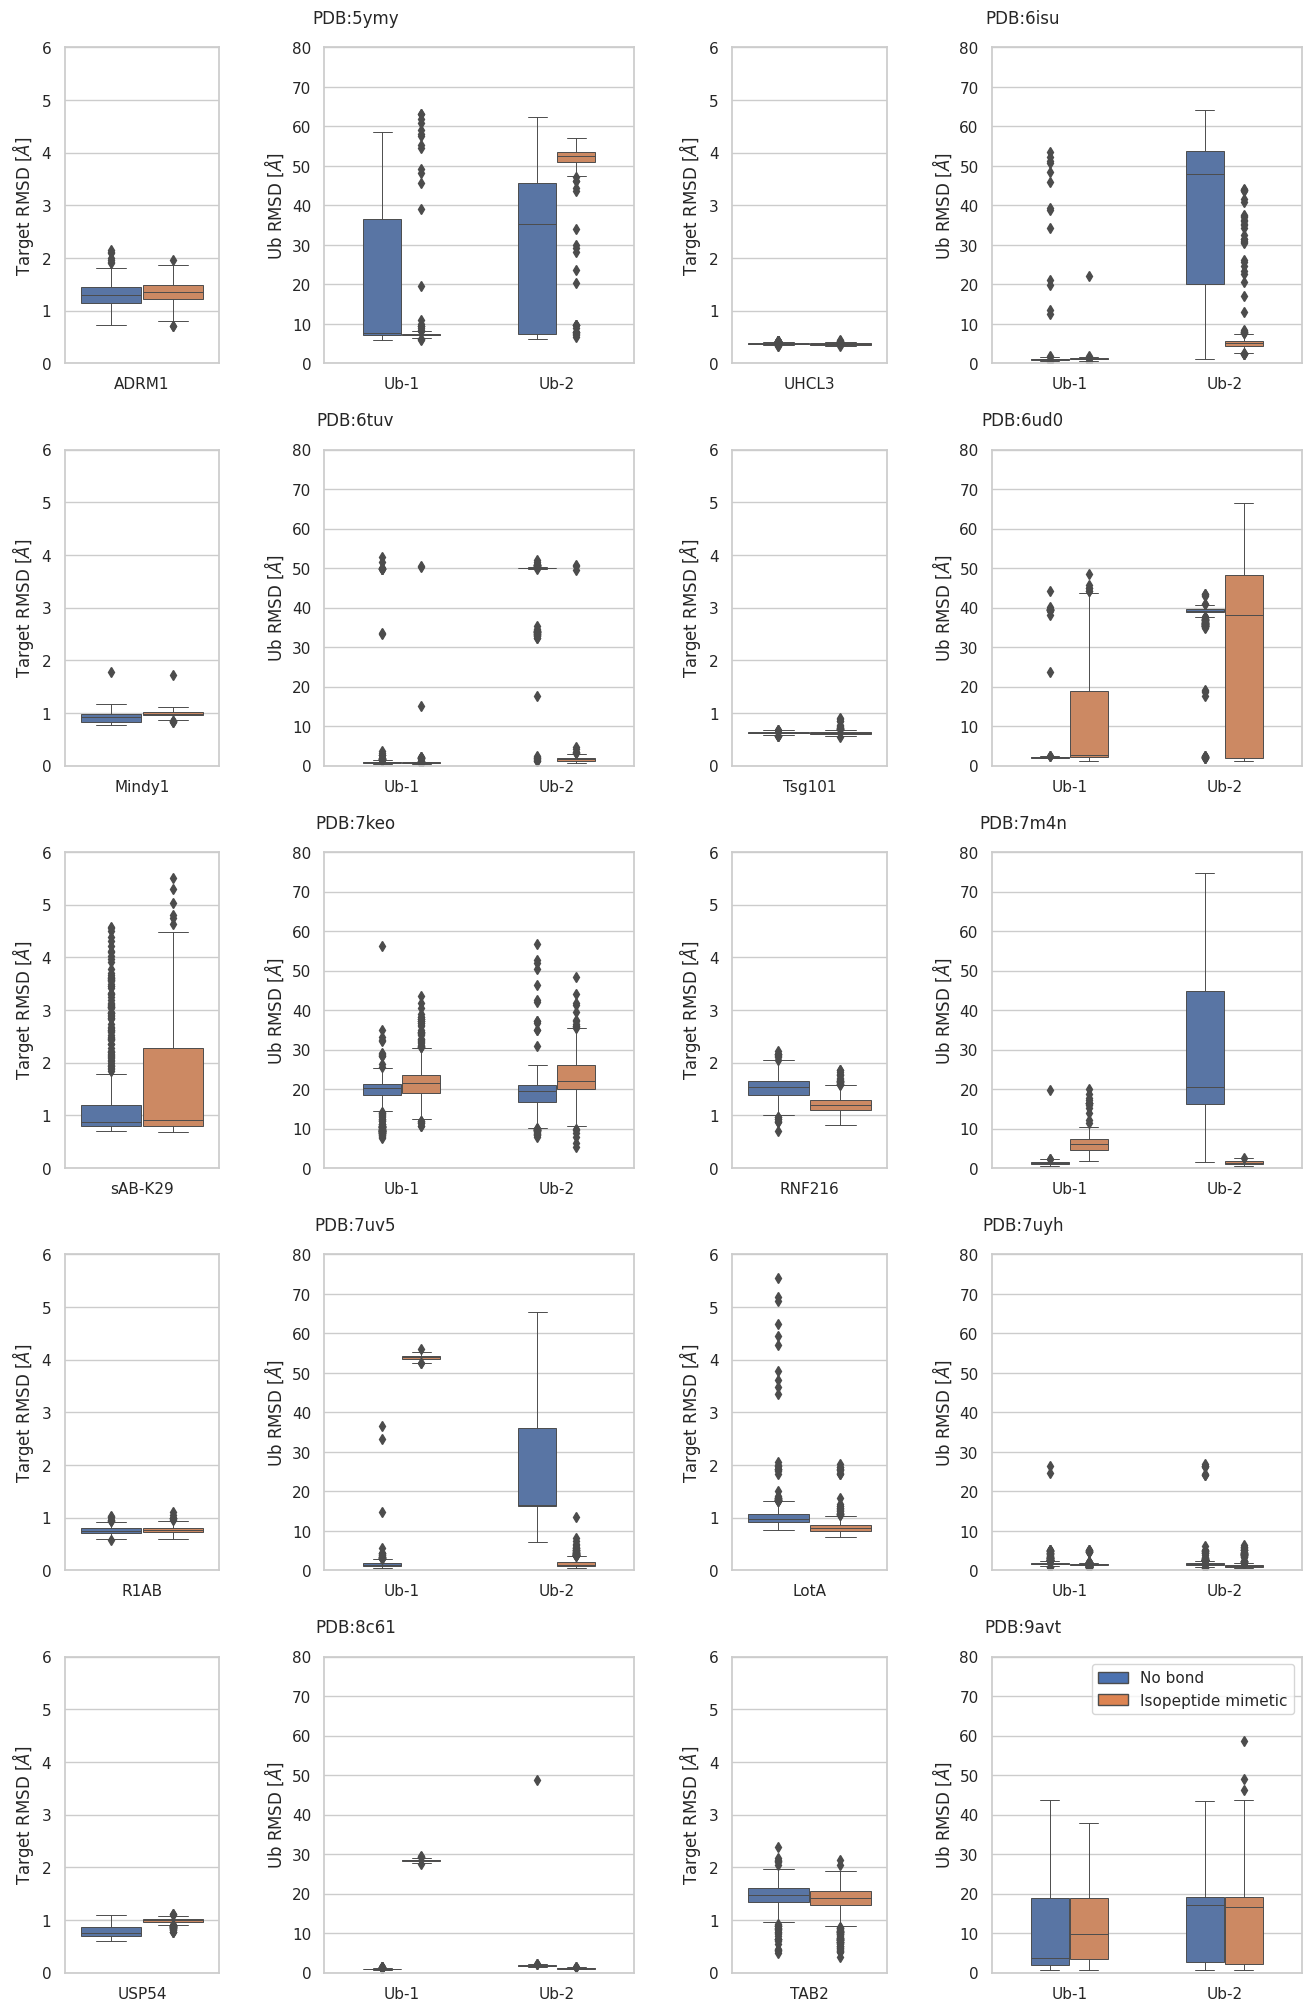

In [54]:
# use to set style of background of plot
plt.rcParams['svg.fonttype'] = 'none'
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# Get the default color palette
colors = seaborn.color_palette()

pdb_names = '5ymy','6isu','6tuv','6ud0','7keo','7m4n','7uv5','7uyh','8c61','9avt'
protein_names = 'ADRM1', 'UHCL3', 'Mindy1', 'Tsg101', 'sAB-K29', 'RNF216', 'R1AB', 'LotA', 'USP54', 'TAB2'

fig = plt.figure(layout="constrained", figsize=(13,20))
gs = GridSpec(5, 6, figure=fig, wspace=0.2, hspace=0.05)


cnt = 0
for pdb, protein in zip(pdb_names, protein_names):
    
    # Get column and row from cnt
    row = int(cnt/2)
    col = (cnt % 2) * 3
    
    ax1 = fig.add_subplot(gs[row, col])
    ax2 = fig.add_subplot(gs[row, col+1:col+3])
    ax2.set_title(f"PDB:{pdb}", x=0.1, y=1.05)

    seaborn.boxplot(x="PDB", y="RMSD", hue=mode, data=target_rmsd_df[target_rmsd_df['PDB'] == pdb], ax=ax1, linewidth=0.7)
    ax1.set_ylabel(r'Target RMSD [$\AA$]')
    ax1.set_xticklabels([protein,])
    ax1.set_ylim([0,6])
    ax1.set_xlabel(None)
    legend = ax1.legend()
    legend.remove()
    
    

    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    seaborn.boxplot(x="Ub-ID", y="RMSD", hue=mode, data=data, ax=ax2, width=0.5, linewidth=0.7)
    ax2.set_ylabel(r'Ub RMSD [$\AA$]')
    if pdb == '8j1p':
        ax2.set_xticklabels([r"Ub-1", r"Ub-2", r"Ub-3"])
    else:
        ax2.set_xticklabels([r"Ub-1", r"Ub-2"])
    if cnt==9:
        if mode == 'bond':
            ax2.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
        elif mode == 'cys':
            ax2.legend(title=None, labels=['No bond', 'Cys'])
        leg = ax2.get_legend()
        leg.legend_handles[0].set_facecolor(colors[0])
        leg.legend_handles[1].set_facecolor(colors[1])
        leg.legend_handles[0].set_linewidth(1)
        leg.legend_handles[1].set_linewidth(1)
    else:
        legend = ax2.legend()
        legend.remove()
        
    ax2.set_xlabel(None)
    ax2.set_ylim([0,80])
    
    cnt += 1


plt.savefig(f"AF3-si-panel-{mode}{linker_suffix}.svg", bbox_inches=0, transparent=True)
plt.savefig(f"AF3-si-panel-{mode}{linker_suffix}.png", bbox_inches=0, transparent=False)
plt.show()

ValueError: min() arg is an empty sequence

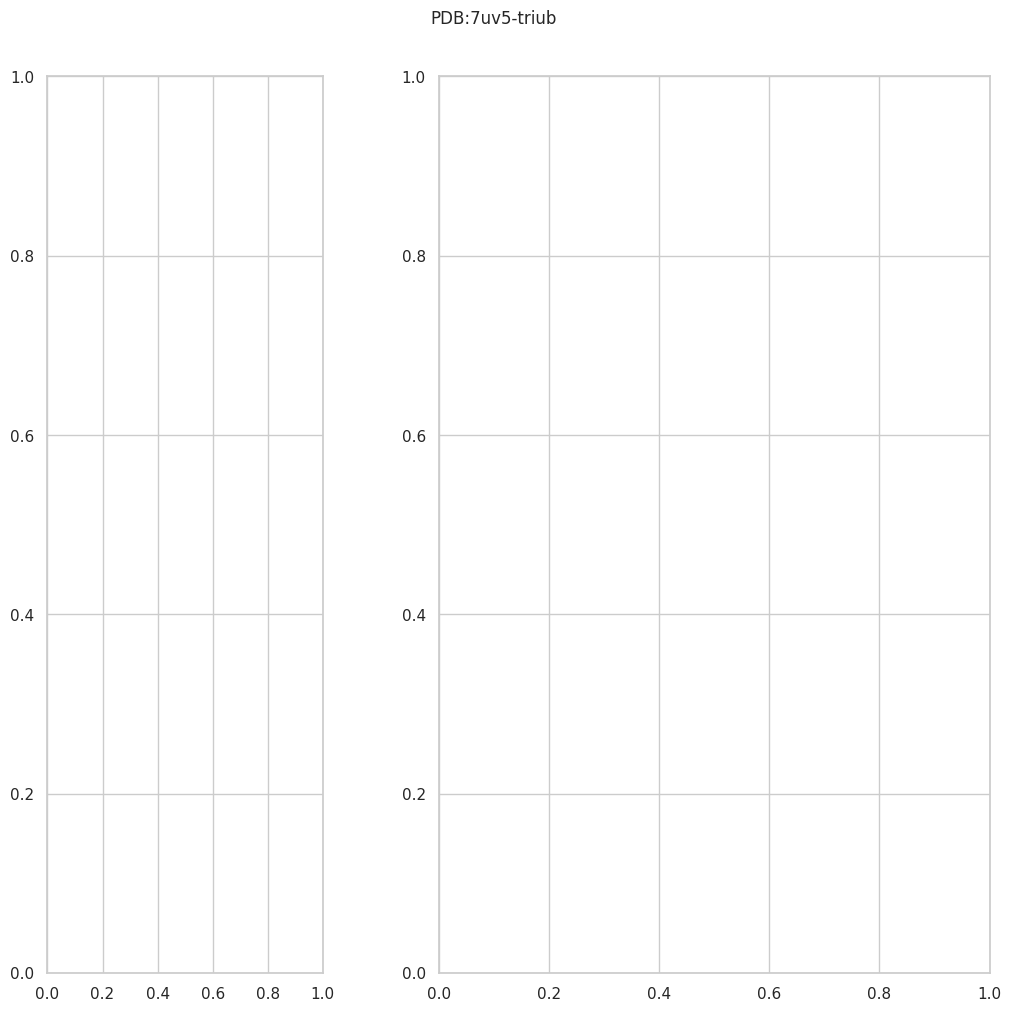

In [58]:
# use to set style of background of plot
plt.rcParams['svg.fonttype'] = 'none'
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# Get the default color palette
colors = seaborn.color_palette()

pdb_names = '8j1p',
protein_names = 'Ufd4',
pdb_names = '8c61-triub', # '7uv5-triub', # '8j1p', # '7uv5-triub'
protein_names = 'USP54', # 'USP54',# 'R1AB', # 'Ufd4', # 'R1AB'
pdb_names = '7uv5-triub',
protein_names = 'R1AB',
fig = plt.figure(layout="constrained", figsize=(10,10))
gs = GridSpec(1, 3, figure=fig, wspace=0.2, hspace=0.05)


cnt = 0
for pdb, protein in zip(pdb_names, protein_names):

    # Get column and row from cnt
    row = int(cnt/2)
    col = (cnt % 2) * 3
    
    ax1 = fig.add_subplot(gs[row, col])
    ax2 = fig.add_subplot(gs[row, col+1:col+3])
    ax2.set_title(f"PDB:{pdb}", x=0.1, y=1.05)

    seaborn.boxplot(x="PDB", y="RMSD", hue=mode, data=target_rmsd_df[target_rmsd_df['PDB'] == pdb], ax=ax1, linewidth=0.7)
    ax1.set_ylabel(r'Target RMSD [$\AA$]')
    ax1.set_xticklabels([protein,])
    ax1.set_ylim([0,6])
    ax1.set_xlabel(None)
    legend = ax1.legend()
    legend.remove()
    
    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    seaborn.boxplot(x="Ub-ID", y="RMSD", hue=mode, data=data, ax=ax2, width=0.5, linewidth=0.7)
    ax2.set_ylabel(r'Ub RMSD [$\AA$]')
    if pdb == '8j1p' or pdb == '8c61-triub':
        ax2.set_xticklabels([r"Ub-1", r"Ub-2", r"Ub-3"])
    else:
        ax2.set_xticklabels([r"Ub-1", r"Ub-2"])
    if cnt==0:
        if mode == 'bond':
            ax2.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
        elif mode == 'cys':
            ax2.legend(title=None, labels=['No bond', 'Cys'])
        leg = ax2.get_legend()
        leg.legend_handles[0].set_facecolor(colors[0])
        leg.legend_handles[1].set_facecolor(colors[1])
        leg.legend_handles[0].set_linewidth(1)
        leg.legend_handles[1].set_linewidth(1)
    else:
        legend = ax2.legend()
        legend.remove()
        
    ax2.set_xlabel(None)
    ax2.set_ylim([0,80])
    
    cnt += 1


plt.savefig(f"SI-Figure3-AF5-{pdb_names[0]}-{mode}{linker_suffix}.svg", bbox_inches=0, transparent=True)
plt.savefig(f"SI-Figure3-AF5-{pdb_names[0]}-{mode}{linker_suffix}.png", bbox_inches=0, transparent=False)
plt.show()

In [9]:
pdb = '8j1p'
target = target_rmsd_df[target_rmsd_df['PDB'] == pdb]


for b in "yes", "no":
    
    print ("Bond: ", b)
    data = target[target[mode] == b]
    print (data['RMSD'].mean(), " +/- ", target['RMSD'].std())

    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    data = data[data[mode] == b]

    for i in range(3):
        print (data[data['Ub-ID'] == str(i)]['RMSD'].mean(), " +/- ", data[data['Ub-ID'] == str(i)]['RMSD'].std())

Bond:  yes
3.425258659663807  +/-  0.4056524138989558
6.629556448057785  +/-  0.34634105548718874
10.795928138768803  +/-  0.24778846218010386
6.466393195667746  +/-  3.5108565858767298
Bond:  no
2.971502775187969  +/-  0.4056524138989558
21.904282559851943  +/-  14.697948509425524
6.511666069104946  +/-  9.439466226639523
32.19951953783161  +/-  23.311075468510193


In [61]:
# Compute significance 

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

models = np.unique(target_rmsd_df['PDB'].to_numpy())

for name in models:
    # Only use the PDB names
    if len(name) != 4:
        continue

    totest = diub_rmsd_df[diub_rmsd_df['PDB'] == name]
    a = totest[totest[mode] == 'no']
    b = totest[totest[mode] == 'yes']
    a = a['RMSD'].to_numpy()
    b = b['RMSD'].to_numpy()

    stat, p = ttest_ind(a, b, equal_var=False)
    print(f"{name} T-test: {stat}, p-value: {p}")
    


5ymy T-test: -25.81084578249657, p-value: 4.9055535477275e-100
6isu T-test: 38.093828586342994, p-value: 4.691751927456977e-166
6tuv T-test: 170.68679977455943, p-value: 0.0
6ud0 T-test: 1.9098325891972372, p-value: 0.056686877143289766
7keo T-test: -13.996210059894606, p-value: 1.2022193526249865e-40
7m4n T-test: 27.74670196687892, p-value: 1.0577678037706976e-104
7uv5 T-test: -55.91205619285183, p-value: 1.6300147818652328e-217
7uyh T-test: 5.905535576511517, p-value: 6.0191514402627155e-09
8c61 T-test: -279.2431845660472, p-value: 0.0
8j1p T-test: 22.284654621281774, p-value: 3.2607979386065524e-77
9avt T-test: 2.0650881230197604, p-value: 0.0392585964099545
